# Assignment 2: Naive Bayes Classifier
## Group Members:
* ### Nils Dunlop, e-mail: gusdunlni@student.gu.se
* ### Francisco Alejandro Erazo Piza, e-mail: guserafr@student.gu.se
* ### Chukwudumebi Ubogu, e-mail: gusuboch@student.gu.se

## Preparatory remarks

### Frequency-counting in Python.

In [575]:
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def read_documents(doc_file):
    """
    Reads a document and returns a list of documents and their corresponding labels.
    """
    docs = []
    labels = []
    categories = []
    with open(doc_file, encoding='utf-8') as f:
        for line in f:
            words = line.strip().split()
            docs.append(words[3:])
            labels.append(words[1])
            categories.append(words[0]) # Used in domain sensitivity section
    return docs, labels, categories

### Reading the review data

In [576]:
def split_data(doc_file, train_split=0.8):
    """
    Splits the data into training and validation sets.
    """
    all_docs, all_labels, all_categories = read_documents(doc_file)
    split_point = int(train_split * len(all_docs))
    train_docs = all_docs[:split_point]
    train_labels = all_labels[:split_point]
    val_docs = all_docs[split_point:]
    val_labels = all_labels[split_point:]
    return train_docs, train_labels, val_docs, val_labels, all_docs, all_labels, all_categories

### Estimating parameters for the Naive Bayes classifier

In [577]:
def train_nb(documents, labels):
    """
    Trains a Naive Bayes classifier given the documents and labels.
    Returns a model containing log probabilities.
    """
    # Initialize counters for each class and a counter for all words
    pos_counter = Counter()
    neg_counter = Counter()
    all_words = set()

    # Count word frequencies per class
    for doc, label in zip(documents, labels):
        if label == 'pos':
            pos_counter.update(doc)
        elif label == 'neg':
            neg_counter.update(doc)
        all_words.update(doc)

    # Total count of words in each class
    total_pos = sum(pos_counter.values())
    total_neg = sum(neg_counter.values())

    # Vocabulary size
    V = len(all_words)

    # Calculate log probabilities with Laplace smoothing
    log_probs = {}
    for word in all_words:
        # Apply laplace smoothing
        log_prob_pos = np.log((pos_counter[word] + 1) / (total_pos + V))
        log_prob_neg = np.log((neg_counter[word] + 1) / (total_neg + V))
        log_probs[word] = {'pos': log_prob_pos, 'neg': log_prob_neg}

    # Calculate the log probabilities of each class
    num_pos = sum(1 for l in labels if l == 'pos')
    num_neg = sum(1 for l in labels if l == 'neg')

    prob_pos = num_pos / len(labels)
    prob_neg = num_neg / len(labels)

    log_prob_pos_class = np.log(prob_pos)
    log_prob_neg_class = np.log(prob_neg)

    log_prob_class = {'pos': log_prob_pos_class, 'neg': log_prob_neg_class}

    return log_probs, log_prob_class

# Splitting the data and then training the model using the training data
train_docs, train_labels, val_docs, val_labels, all_docs, all_labels, all_categories = split_data('reviews.txt')
model, log_prob_class = train_nb(train_docs, train_labels)

# Printing 5 instances of the model for verification
list(model.items())[:5], log_prob_class

([('sappy', {'pos': -11.766647363338413, 'neg': -11.15274829148272}),
  ('sentenses', {'pos': -13.558406832566469, 'neg': -12.857496383721145}),
  ('.they', {'pos': -12.865259652006523, 'neg': -13.55064356428109}),
  ('unsure', {'pos': -11.948968920132367, 'neg': -11.94120565184699}),
  ('invariably', {'pos': -12.172112471446578, 'neg': -11.758884095053036})],
 {'pos': -0.6761896870922498, 'neg': -0.7103971982200179})

### Classifying new documents

In [578]:
def score_doc_label(document, label, model, log_prob_class):
    """
    Computes logarithm probability of the observed words in a document given a sentiment label.
    """
    # Start with the log probability of the label
    log_prob = log_prob_class[label]

    # Add the log probability of each word in the document
    for word in document:
        if word in model:
            log_prob += model[word][label]
        else:
            # If the word is not in the model, it's an unseen word, we choose to ignore it
            pass

    return log_prob

In [579]:
# Sanity Check 1: Testing with the word "great"
log_prob_pos_great = score_doc_label(["great"], "pos", model, log_prob_class)
log_prob_neg_great = score_doc_label(["great"], "neg", model, log_prob_class)
prob_pos_great = np.exp(log_prob_pos_great)
prob_neg_great = np.exp(log_prob_neg_great)

# Sanity Check 2: Testing with the word "bad"
log_prob_pos_bad = score_doc_label(["bad"], "pos", model, log_prob_class)
log_prob_neg_bad = score_doc_label(["bad"], "neg", model, log_prob_class)
prob_pos_bad = np.exp(log_prob_pos_bad)
prob_neg_bad = np.exp(log_prob_neg_bad)

# Sanity Check 3: Testing with the document ['a', 'top-quality', 'performance']
log_prob_pos_doc = score_doc_label(['a', 'top-quality', 'performance'], "pos", model, log_prob_class)
log_prob_neg_doc = score_doc_label(['a', 'top-quality', 'performance'], "neg", model, log_prob_class)

print("Sanity Check 1:")
print(f"Probability of 'great' given positive class: {prob_pos_great}")
print(f"Probability of 'great' given negative class: {prob_neg_great}")

print("\nSanity Check 2:")
print(f"Probability of 'bad' given positive class: {prob_pos_bad}")
print(f"Probability of 'bad' given negative class: {prob_neg_bad}")

print("\nSanity Check 3:")
print(f"Log probability of ['a', 'top-quality', 'performance'] given positive class: {log_prob_pos_doc}")
print(f"Log probability of ['a', 'top-quality', 'performance'] given negative class: {log_prob_neg_doc}")

Sanity Check 1:
Probability of 'great' given positive class: 0.0013212141496043825
Probability of 'great' given negative class: 0.0005283997934747295

Sanity Check 2:
Probability of 'bad' given positive class: 0.00017230368700664423
Probability of 'bad' given negative class: 0.0004547440646873432

Sanity Check 3:
Log probability of ['a', 'top-quality', 'performance'] given positive class: -12.807858361140351
Log probability of ['a', 'top-quality', 'performance'] given negative class: -13.486891735775352


In [580]:
def classify_nb(document, model, log_prob_class):
    """
    Classify a new document using the Naive Bayes classifier.
    """
    # Compute the log probability for each class
    log_prob_pos = score_doc_label(document, "pos", model, log_prob_class)
    log_prob_neg = score_doc_label(document, "neg", model, log_prob_class)

    # Return the class with the higher log probability
    if log_prob_pos > log_prob_neg:
        return "pos"
    else:
        return "neg"

In [581]:
# Sanity checks on small test documents
test_docs = [["great"], ["bad"], ["amazing"], ["terrible"], ['a', 'top-quality', 'performance']]

# Applying the classify_nb function to the test documents
classified_docs = []
for doc in test_docs:
    classification = classify_nb(doc, model, log_prob_class)
    classified_docs.append((doc, classification))

classified_docs

[(['great'], 'pos'),
 (['bad'], 'neg'),
 (['amazing'], 'pos'),
 (['terrible'], 'neg'),
 (['a', 'top-quality', 'performance'], 'pos')]

### Evaluating the classifier

In [582]:
def classify_documents(docs, model, log_prob_class):
    """
    Classifies documents in the provided collection. Handling both textual and numerical data.
    """
    predictions = []
    for doc in docs:
        prediction = classify_nb(doc, model, log_prob_class)
        predictions.append(prediction)
    return predictions

In [583]:
def accuracy(true_labels, guessed_labels):
    """
    Computes the accuracy of the classifier.
    """
    correct_count = 0

    for t, g in zip(true_labels, guessed_labels):
        if t == g:
            correct_count += 1
    
    acc = correct_count / len(true_labels)
    return acc

In [584]:
def precision_recall_f1(true_labels, predicted_labels):
    # Modified to handle multi-class labels
    unique_labels = set(true_labels)
    precision, recall, f1 = {}, {}, {}

    for label in unique_labels:
        true_positives = sum((true == label) and (pred == label) for true, pred in zip(true_labels, predicted_labels))
        false_positives = sum((true != label) and (pred == label) for true, pred in zip(true_labels, predicted_labels))
        false_negatives = sum((true == label) and (pred != label) for true, pred in zip(true_labels, predicted_labels))

        label_precision = true_positives / (true_positives + false_positives) if true_positives + false_positives > 0 else 0
        label_recall = true_positives / (true_positives + false_negatives) if true_positives + false_negatives > 0 else 0
        label_f1 = 2 * (label_precision * label_recall) / (label_precision + label_recall) if label_precision + label_recall > 0 else 0

        precision[label] = label_precision
        recall[label] = label_recall
        f1[label] = label_f1

    return precision, recall, f1

In [585]:
# Calculating the accuracy, precision, recall, and F1 score
predicted_labels = classify_documents(val_docs, model, log_prob_class)
accuracy_result = accuracy(val_labels, predicted_labels)
precision, recall, f1_score = precision_recall_f1(val_labels, predicted_labels)

print(f"Accuracy: {accuracy_result} \nPrecision: {precision['pos']}\nRecall: {recall['pos']}\nF1 score: {f1_score['pos']}")

Accuracy: 0.8153587914393622 
Precision: 0.8237965485921889
Recall: 0.7866435385949696
F1 score: 0.8047914818101153


### What is the difference between F1 score and accuracy?

**Accuracy**
Accuracy is a measures the proportion of correctly predicted instances out of all the predictions made. In short, it is the number of correct predictions divided by the total number of predictions. Accuracy gives us a general idea of how well the model is performing.

**Precision**
F1 score is a slightly more nuanced metric. It is the harmonic mean of precision and recall. Precision is the ratio of true positives to all positive predictions. Recall is the ratio of true positives to all actual positive instances. F1 score balances precision and recall, providing a more holistic view of how well the model is performing especially when the classes are imbalanced.

### Error Analysis
We analyzed the first 10 documents and their corresponding prediction. Below you will see three instances which were harder to predict: 
 
1. Document about an Iron **(Predicted: Negative)**:

* Content: The document starts with a warning not to buy the iron, mentions it's fabulous when it works, but then highlights that it broke in less than a week and had other issues.
* Analysis: The prediction as negative seems correct. The initial positive remark "it's fabulous" probably was outweighed by the predominantly negative context.

2. Document about Madame Bovary **(Predicted: Positive)**:
* Content: The review seems to be more about the characters in the story, with a mix of critique and appreciation for the adaptation and performances.
* Analysis: This document was tricky to label as it wrote polarizing thoughts about the book. We assume that the classifier picked up on more positive aspects than negative aspects of the book, leading to a positive prediction. 

3. Document about Microsoft Office **(Predicted: Negative)**:
* Content: The reviewer criticizes the new interface of Microsoft Office, finding it infuriating and less efficient.
* Analysis: The negative prediction aligns with the strong criticism expressed in the document.

Overall the classifier seemed to predict well the sentiment expressed in the first 10 documents. The more challenging cases for the classifier could be the ones with mixed sentiments or when the sentiment is expressed in a not so straightforward way such as the Madame Bovary document.

### Cross-validation

In [586]:
def cross_validation_10_fold(all_docs, all_labels, N=10):
    """
    Performs 10-fold cross-validation. 
    """
    accuracy_scores = []
    for fold_nbr in range(N):
        split_point_1 = int(float(fold_nbr)/N*len(all_docs))
        split_point_2 = int(float(fold_nbr+1)/N*len(all_docs))

        train_docs_fold = all_docs[:split_point_1] + all_docs[split_point_2:]
        train_labels_fold = all_labels[:split_point_1] + all_labels[split_point_2:]
        val_docs_fold = all_docs[split_point_1:split_point_2]
        val_labels_fold = all_labels[split_point_1:split_point_2]

        model, log_prob_class = train_nb(train_docs_fold, train_labels_fold)
        predicted_labels = classify_documents(val_docs_fold, model, log_prob_class)
        accuracy_scores.append(accuracy(val_labels_fold, predicted_labels))

    return sum(accuracy_scores) / N

In [587]:
def cross_validation_loocv(all_docs, all_labels, max_iterations=100):
    """
    Performs leave-one-out cross-validation. 
    """
    accuracy_scores = []
    for i in range(min(max_iterations, len(all_docs))):
        train_docs_fold = all_docs[:i] + all_docs[i+1:]
        train_labels_fold = all_labels[:i] + all_labels[i+1:]
        val_docs_fold = [all_docs[i]]
        val_labels_fold = [all_labels[i]]

        model, log_prob_class = train_nb(train_docs_fold, train_labels_fold)
        predicted_labels = classify_documents(val_docs_fold, model, log_prob_class)
        accuracy_scores.append(accuracy(val_labels_fold, predicted_labels))

    return sum(accuracy_scores) / len(accuracy_scores)

In [588]:
# 10-Fold Cross-Validation
avg_accuracy_10_fold = cross_validation_10_fold(all_docs, all_labels, N=10)
print("Average Accuracy (10-Fold Cross-Validation):", avg_accuracy_10_fold)

# LOOCV
avg_accuracy_loocv = cross_validation_loocv(all_docs, all_labels, max_iterations=100)
print("Average Accuracy (LOOCV, first 100 iterations):", avg_accuracy_loocv)

Average Accuracy (10-Fold Cross-Validation): 0.8076216900805256
Average Accuracy (LOOCV, first 100 iterations): 0.83


### Cross-validation results
* **10-Fold Cross-Validation**: Achieved an average accuracy of about 0.808. This method offers a balanced evaluation, as it trains and validates across different subsets of the data resulting in a consistent classifier performance.
* **LOOCV (100 Iterations)**: Showed a slightly higher average accuracy of 0.83. By training on nearly all available data for each test case, this method offers a more accurate evaluation of the classifier performance. However, it is computationally expensive and can be slow to run.

The 10-fold and LOOCV results indicate a reliable classifier, with 10-fold offering a broader accuracy measure and LOOCV providing more detailed validation, however with higher computational demands.

### Domain sensitivity

In [589]:
def filter_by_category(docs, labels, categories, category_name):
    """
    Filters the reviews by a specific category.
    """
    filtered_docs = []
    filtered_labels = []

    for doc, label, cat in zip(docs, labels, categories):
        if cat == category_name:
            filtered_docs.append(doc)
            filtered_labels.append(label)

    return filtered_docs, filtered_labels

In [590]:
# Filter documents by category
camera_docs, camera_labels = filter_by_category(all_docs, all_labels, all_categories, 'camera')
book_docs, book_labels = filter_by_category(all_docs, all_labels, all_categories, 'books')

#### Split the data into training and validation sets

In [591]:
def split_pre_filtered_data(docs, labels, train_split=0.8):
    """
    Split the filtered documents and labels into training and validation sets.
    """
    split_point = int(train_split * len(docs))
    train_docs = docs[:split_point]
    train_labels = labels[:split_point]
    val_docs = docs[split_point:]
    val_labels = labels[split_point:]
    return train_docs, train_labels, val_docs, val_labels

In [592]:
camera_train_docs, camera_train_labels, camera_val_docs, camera_val_labels = split_pre_filtered_data(camera_docs, camera_labels)
book_train_docs, book_train_labels, book_val_docs, book_val_labels = split_pre_filtered_data(book_docs, book_labels)

### Train the classifier on the camera and book reviews

In [593]:
# Train classifier for camera reviews
camera_model, camera_log_prob_class = train_nb(camera_train_docs, camera_train_labels)

# Evaluate classifier on camera validation set
camera_predicted_labels = classify_documents(camera_val_docs, camera_model, camera_log_prob_class)
camera_accuracy = accuracy(camera_val_labels, camera_predicted_labels)

# Train classifier for book reviews
book_model, book_log_prob_class = train_nb(book_train_docs, book_train_labels)

# Evaluate classifier on book validation set
book_predicted_labels = classify_documents(book_val_docs, book_model, book_log_prob_class)
book_accuracy = accuracy(book_val_labels, book_predicted_labels)

# Evaluate the classifiers on the opposite domain
camera_on_book_accuracy = accuracy(book_val_labels, classify_documents(book_val_docs, camera_model, camera_log_prob_class))
book_on_camera_accuracy = accuracy(camera_val_labels, classify_documents(camera_val_docs, book_model, book_log_prob_class))

# Show the results
print(f"Camera Classifier on Camera Reviews Accuracy: {camera_accuracy}")
print(f"Book Classifier on Book Reviews Accuracy: {book_accuracy}")
print(f"Camera Classifier on Book Reviews Accuracy: {camera_on_book_accuracy}")
print(f"Book Classifier on Camera Reviews Accuracy: {book_on_camera_accuracy}")

Camera Classifier on Camera Reviews Accuracy: 0.8675
Book Classifier on Book Reviews Accuracy: 0.7925
Camera Classifier on Book Reviews Accuracy: 0.71
Book Classifier on Camera Reviews Accuracy: 0.65


### Classifier Performance Analysis
#### Within-Domain Accuracy
* **Camera Classifier on Camera Reviews**: Achieved an accuracy of 0.8675. The high accuracy indicates that the classifier is well-tuned to the specific features and patterns present in camera reviews. 
* **Book Classifier on Book Reviews**: Accomplished an accuracy of 0.7925. While slightly lower than the camera classifier, it still shows a strong performance suggesting a good model fit to book review data.

#### Cross-Domain Accuracy
* **Camera Classifier on Book Reviews**: The accuracy dropped to 0.71 when the camera classifier was applied to book reviews. This significant drop in accuracy highlights the domain sensitivity. In turn indicating that features learned from camera reviews are not as effective in classifying book reviews.
* **Book Classifier on Camera Reviews**: Saw an even further drop in accuracy to 0.65. Similarly to the camera classifier, the book classifier was not able to generalize well to the camera reviews.

#### Conclusion
The results demonstrate a clear importance of domain sensitivity. Both classifiers perform well within their respective domains showing that they have learned domain-specific features effectively. However, when applied to a different domain their accuracy drops significantly demonstrating the importance of domain-specific language and features in text classification tasks. 


### Naive Bayes for numerical data

In [594]:
# Read the data
df = pd.read_csv('iris.csv')

def train_nb_numerical(dataframe, labels):
    """
    Trains a Gaussian Naive Bayes classifier and returns model and log probabilities of classes.
    """
    # Initialize dictionary and get the unique labels
    model = {}
    unique_labels = dataframe[labels].unique()

    # Calculate the total number of samples
    total_samples = len(dataframe)

    # Initialize dictionary for log probabilities of each class
    log_prob_class = {}

    # Calculate the mean, standard deviation, and log probability for each class
    for label in unique_labels:
        class_data = dataframe[dataframe[labels] == label]
        features = class_data.drop(labels, axis=1)
        mean = features.mean(numeric_only=True)
        std = features.std(numeric_only=True)

        # Store mean and std in the model
        model[label] = {'mean': mean, 'std': std}

        # Calculate and store the log probability of the class
        log_prob_class[label] = np.log(len(class_data) / total_samples)

    return model, log_prob_class

In [595]:
def score_doc_label_numerical(document, label, model):
    """
    Computes the log probability of a numerical document given a label.
    """
    mean = model[label]['mean']
    std = model[label]['std']
    log_prob = 0

    # Calculate the log probability for each feature
    for feature_value, feature_mean, feature_std in zip(document, mean, std):
        # Apply the Gaussian Naive Bayes formula
        log_prob += np.log(1 / (np.sqrt(2 * np.pi) * feature_std)) - ((feature_value - feature_mean) ** 2) / (2 * feature_std ** 2)

    return log_prob

In [596]:
def classify_nb_numerical(document, model):
    """
    Classify a numerical document using a Naive Bayes model.
    """
    # Initialize a dictionary to store log probabilities for each label
    log_probs = {}

    # Compute the log probability for each class
    for label in model.keys():
        log_probs[label] = score_doc_label_numerical(document, label, model)

    # Return the label with the highest log probability
    return max(log_probs, key=log_probs.get)

In [597]:
# Train the model
model, num_log_prob_class = train_nb_numerical(df, 'species')

# Initialize an empty list to store predictions
predictions = []

# Iterate over the rows in the dataframe
for index, row in df.iterrows():
    iris_document = row.drop('species').tolist()

    # Compute the log probability for each class
    log_probs = {label: score_doc_label_numerical(iris_document, label, model) for label in model}
    predicted_class = max(log_probs, key=log_probs.get)
    predictions.append(predicted_class)

# Add the predictions to the dataframe
df['predicted_species'] = predictions
df['correct_prediction'] = df['species'] == df['predicted_species']

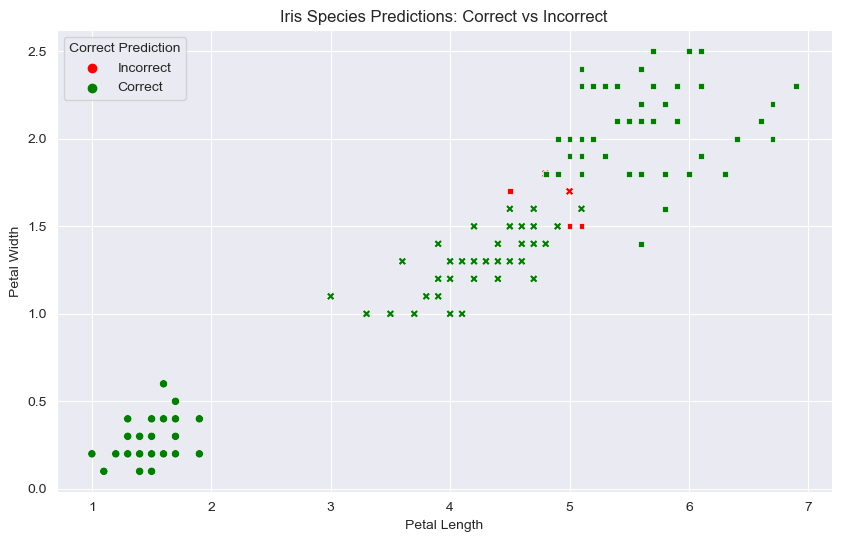

In [598]:
# Plot the correct and incorrect predictions
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='petal_length', y='petal_width', hue='correct_prediction', style='species', palette={True: "green", False: "red"})
plt.title('Iris Species Predictions: Correct vs Incorrect')
plt.xlabel('Petal Length')
plt.ylabel('Petal Width')
handles, _ = plt.gca().get_legend_handles_labels()
plt.legend(handles=handles[1:], labels=['Incorrect', 'Correct'], title='Correct Prediction', loc='upper left')
plt.show()

In [599]:
def cross_validation_10_fold_numerical(dataframe, label_column, N=10):
    """
    Performs 10-fold cross-validation on a DataFrame with numerical data.
    """
    accuracy_scores, all_precision_scores, all_recall_scores, all_f1_scores = [], [], [], []
    n = len(dataframe)

    # Shuffle the DataFrame
    dataframe = dataframe.sample(frac=1, random_state=1).reset_index(drop=True)

    for fold_nbr in range(N):
        split_point_1 = int(fold_nbr / N * n)
        split_point_2 = int((fold_nbr + 1) / N * n)

        # Splitting DataFrame into training and validation sets
        train_df = pd.concat([dataframe.iloc[:split_point_1], dataframe.iloc[split_point_2:]])
        val_df = dataframe.iloc[split_point_1:split_point_2]

        # Training the model
        model, num_log_prob_class = train_nb_numerical(train_df, label_column)

        # Initialize an empty list to store predictions
        predicted_labels = []

        # Extracting validation labels
        val_labels = val_df[label_column].tolist()

        # Classifying each document in the validation set
        for index, row in val_df.iterrows():
            # Select the feature columns
            document = row[['sepal_length', 'sepal_width', 'petal_length', 'petal_width']].tolist()

            # Classify the document
            predicted_label = classify_nb_numerical(document, model)
            predicted_labels.append(predicted_label)

        # Calculating accuracy for the fold
        accuracy_scores.append(accuracy(val_labels, predicted_labels))

        # Calculate precision, recall, and F1 scores for the fold
        precision, recall, f1 = precision_recall_f1(val_labels, predicted_labels)
        all_precision_scores.append(precision)
        all_recall_scores.append(recall)
        all_f1_scores.append(f1)

    # Calculate the average scores
    average_accuracy = sum(accuracy_scores) / N
    num_labels = len(set(dataframe[label_column]))
    average_precision = sum(sum(precision.values()) for precision in all_precision_scores) / (N * num_labels)
    average_recall = sum(sum(recall.values()) for recall in all_recall_scores) / (N * num_labels)
    average_f1 = sum(sum(f1.values()) for f1 in all_f1_scores) / (N * num_labels)

    return average_accuracy, average_precision, average_recall, average_f1

In [600]:
average_accuracy, average_precision, average_recall, average_f1 = cross_validation_10_fold_numerical(df, 'species')

print(f"Average 10-Fold Cross-Validation Accuracy: {average_accuracy}")
print(f"Average Precision: {average_precision}")
print(f"Average Recall: {average_recall}")
print(f"Average F1 Score: {average_f1}")

Average 10-Fold Cross-Validation Accuracy: 0.9533333333333335
Average Precision: 0.9472222222222222
Average Recall: 0.9523809523809524
Average F1 Score: 0.945929625929626


It seems like the Gaussian Naive Bayes classifier is performing well on the iris dataset, achieving a high average accuracy of 95.33% and F1 score of 94.59% over the 10-fold cross-validation. Indicating that the model is effectively learning and making accurate predictions on the given dataset. 

- The high accuracy indicates that the classifier is effective in correctly predicting the species of the iris flowers. It suggests that the model generalizes well on the validation data, which is a positive outcome.
- The F1 score as it is mentioned early is a metric that considers both precision and recall. The high F1 score suggests a good balance between precision and recall, indicating that the model performs well in correctly identifying positive instances while minimizing false positives and false negatives.
- Gaussian Naive Bayes assumes that the features follow a Gaussian distribution, the good performance might indicate that this assumption is reasonable for the iris dataset because the model is capturing the patterns in the data effectively. However, further analysis of the feature distributions could provide more insights into this assumption. 
- The use of 10-fold cross-validation provides a robust evaluation of the model. It helps ensure that the model's performance is consistent across different subsets of the data, reducing the risk of overfitting.

## References:
* Add 1 (Laplace) Smoothing: https://courses.engr.illinois.edu/cs447/fa2018/Slides/Lecture04.pdf